In [239]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [242]:

from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import math
import os
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None


user = "000"
hour = 0
train_month = "200904"
test_month = "200905"
confidence_thrshld = 0.05 #minimum confidence for path predictions
month = "200904" #model to be used for path predictions
state_d_thrhld = 200
lat = 39.99998468 #start lat for path predictions
lon = 116.3272194 #start lon for path predictions
src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

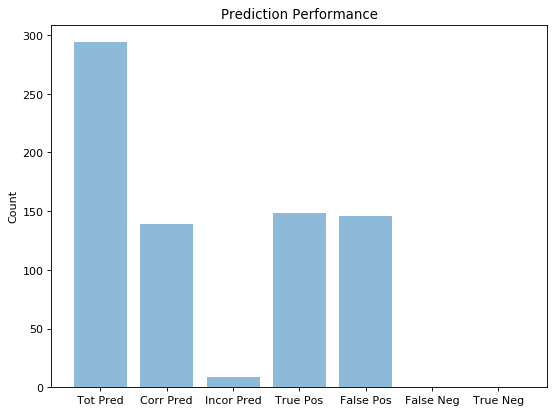

In [243]:

#True positives, true negatives, false positives, false negatives, accuracy

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dlat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dlon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


# calculate prediction parameters
def check_pred(indx_row):
    global predic_df
    global tobepredicted_df
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    true_pred = False
    visit_next_hour = False
    visit_count_next_hour = 0
    curr_hour = tobepredicted_df.loc[indx_row, 'Hour']
    curr_date = tobepredicted_df.loc[indx_row, 'Date']

    # check if there are points found in next hour
    for k in range(indx_row + 1, len(tobepredicted_df)):

        next_hour = tobepredicted_df.loc[k, 'Hour']
        next_date = tobepredicted_df.loc[k, 'Date']

        if (curr_hour != next_hour) or (curr_date != next_date):

            if (curr_hour == 23) and (next_date == curr_date + timedelta(days=1)) and (next_hour == 0):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            elif (next_date == curr_date) and (next_hour == curr_hour + 1):
                visit_next_hour = True
                visit_count_next_hour = visit_count_next_hour + 1
            else:
                break

    # visit encountered in next hour: Either:
    #      A. True Positive, or
    #      B. False Negative
    if visit_next_hour == True:

        # B. False Negative
        if predic_df.empty:
            false_neg = false_neg + 1
        # A. True Positive
        else:
            true_pos = true_pos + 1

            # check if prediction is correct or incorrect
            for l in range(1, visit_count_next_hour + 1):

                true_lat = tobepredicted_df['StateMeanLat'][indx_row + l]
                true_lon = tobepredicted_df['StateMeanLon'][indx_row + l]
                true_pred = False
                for i in range(0, len(predic_df)):

                    pred_lat = predic_df.loc[i, 'Latitude']
                    pred_lon = predic_df.loc[i, 'Longitude']

                    if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                        correct_pred = correct_pred + 1
                        true_pred = True
                        break

                if true_pred == True:
                    break

            if true_pred == False:
                incorrect_pred = incorrect_pred + 1

    # visit not encountered in next hour: Either:
    #      A. False Positive, or
    #      B. True Negative
    else:
        # B. True Negative
        if predic_df.empty:
            true_neg = true_neg + 1
        # A. False Positive
        else:
            false_pos = false_pos + 1


def predict():
    global trained_model_df
    global staypts_df
    global tobepredicted_df
    global predic_df
    global total_pred
    global correct_pred
    global incorrect_pred
    global true_pos
    global false_pos
    global true_neg
    global false_neg

    pred_made = False
    tobepredicted_df = staypts_df[['StateId', 'StateMeanLat', 'StateMeanLon', 'Timestamp']]
    tobepredicted_df.Timestamp = pd.to_datetime(tobepredicted_df.Timestamp)
    tobepredicted_df['Date'] = tobepredicted_df['Timestamp'].dt.date
    tobepredicted_df['Hour'] = tobepredicted_df['Timestamp'].dt.hour
    tobepredicted_df = tobepredicted_df.drop(['Timestamp'], axis=1)
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    file_name = "Predictions.csv"
    file = dest_predicted_dir + file_name

    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    for j in range(0, len(tobepredicted_df)):

        new_lat = tobepredicted_df['StateMeanLat'][j]
        new_lon = tobepredicted_df['StateMeanLon'][j]
        hour = tobepredicted_df.loc[j, 'Hour']

        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            predic_df = pd.DataFrame()
            pred_made = False

            if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:
                # prediction is made
                pred_made = True
                total_pred = total_pred + 1

                cluster_id = trained_model_df['StateId'][i]
                
                jmp_dat = False
                if hour == 23:
                    jmp_dat = True

                if jmp_dat == True:
                    from_col_no = 5
                    to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                    predic_df = trained_model_df.iloc[i + 1:i + 2, from_col_no:to_col_no]
                else:
                    from_col_no = trained_model_df['StateId'].nunique() * (hour+1) + 5
                    to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                    predic_df = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no]

                predic_df = predic_df.T
                predic_df['StateId'] = cluster_id
                predic_df['PredState'] = predic_df.index
                predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'StateId', 'PredState']

                # predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                predic_df = predic_df.sort_values('Probability', ascending=False)
                predic_df['DateHour'] = str(tobepredicted_df['Date'][j]) + " " + str(tobepredicted_df['Hour'][j])
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for k in range(0, len(predic_df)):
                    # import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['PredState'][k]))
                    add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[k, 'Address'] = add
                    predic_df.loc[k, 'Latitude'] = lat
                    predic_df.loc[k, 'Longitude'] = lon

                #                 print("Prediction --\n")
                #                 print("Current hour - " + str(hour))
                #                 print("\nPrediction\n")
                #                 print(predic_df)

                predic_df.to_csv(file, mode='a')
                break

        # if prediction was made, calculate prediction parameters
        if pred_made == True:
            check_pred(j)

    # plot parameters
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    objects = ('Tot Pred', 'Corr Pred', 'Incor Pred', 'True Pos', 'False Pos', 'False Neg', 'True Neg')
    y_pos = np.arange(len(objects))
    performance = [total_pred, correct_pred, incorrect_pred, true_pos, false_pos, false_neg, true_neg]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Count')
    plt.title('Prediction Performance')
    destpng = dest_predicted_dir + "pred performance.png"
    plt.savefig(destpng)
    plt.show()

    # prediction parameters
    if total_pred != 0:
        acc = correct_pred / total_pred * 100
    else:
        acc = 0

    if true_pos + false_pos != 0:
        true_pos_rate = true_pos / (true_pos + false_neg) * 100
    else:
        true_pos_rate = 0

    if total_pred != 0:
        acc_pos = (true_pos + true_neg) / total_pred * 100
    else:
        acc_pos = 0

    if true_pos + false_pos != 0:
        pos_pred_value = true_pos / (true_pos + false_pos) * 100
        false_dis_rate = false_pos / (true_pos + false_pos) * 100
    else:
        pos_pred_value = 0
        false_dis_rate = 0

    prediction_perf = ("Total Predictions: " + str(total_pred) + "\nCorrect Predictions: " + str(correct_pred) +
                       "\nIncorrect Predictions: " + str(incorrect_pred) +
                       "\nAccuracy%: " + str(acc) +
                       "\nTrue Positives: " + str(true_pos) + "\nFalse Positives: " + str(false_pos) +
                       "\nFalse Negatives: " + str(false_neg) + "\nTrue Negatives: " + str(true_neg) +
                       "\nTrue positive rate(Recall)%: " + str(true_pos_rate) +
                       # "\nFalse positive rate(Fall-out): " + str(false_pos_rate) +
                       "\nAccuracy Positives%: " + str(acc_pos) +
                       "\nPositive predictive value(Precision)%: " + str(pos_pred_value) +
                       "\nFalse discovery rate%: " + str(false_dis_rate))
    text_file = dest_predicted_dir + "corr pred ratio " + str(acc) + " .txt"
    f = open(text_file, "w+")
    f.write(prediction_perf)


# -----------------------------------------------------------------------------------------
# train_month = "200705"
# test_month = "200704"
# user = "021"
# state_d_thrhld = 200
# src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"
    
tobepredicted_df = pd.DataFrame()
predic_df = pd.DataFrame()

# staypoints file path
stay_points_file = src_path + "/User " + user + "/" + test_month + "/staypoints/staypoints.csv"
# trained model
trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
# predicted file
dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

# counts
total_pred = 0
correct_pred = 0
incorrect_pred = 0
true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

trained_model_df = pd.read_csv(trained_model_file, header=0)
staypts_df = pd.read_csv(stay_points_file, header=0, sep='\t')

predict()


In [244]:

#Cosine Similarity

# Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def find_similarity(pred_prob, act_prob_all):
    return math.acos(dotproduct(pred_prob, act_prob_all) / (length(pred_prob) * length(act_prob_all)))

# def find_similarity(pred_prob, act_prob_all):
#     result = 1 - spatial.distance.cosine(pred_prob, act_prob_all)
#     return result

# calculate prediction parameters
def check_pred(hour, indx_row):
    global predic_df
    global hrywghts_df
    global similarity_arr

    pred_prob = predic_df['PredProbability'].values
    act_prob_all = [0] * len(pred_prob)
    curr_date = hrywghts_df.loc[indx_row, 'Date']
    state_wght = hrywghts_df.loc[indx_row, str(hour)]

    jmp_dat = False
    if hour == 23:
        jmp_dat = True

    # check if there are points found in next hour
    hrywghts_day_df = hrywghts_df.loc[hrywghts_df['Date'] == curr_date]
    hrywghts_day_df = hrywghts_day_df.reset_index(drop=True)
    for k in range(0, len(hrywghts_day_df)):
        if jmp_dat == True:
            if k + 1 < len(hrywghts_day_df):
                next_hour = 0
                row = k + 1
            else:
                break
        else:
            next_hour = hour + 1
            row = k

        if hrywghts_day_df.loc[row, str(next_hour)] != 0:

            true_lat = hrywghts_day_df['AvgLat'][row]
            true_lon = hrywghts_day_df['AvgLon'][row]

            for i in range(0, len(predic_df)):
                pred_lat = predic_df.loc[i, 'Latitude']
                pred_lon = predic_df.loc[i, 'Longitude']

                if meters(true_lat, true_lon, pred_lat, pred_lon) <= state_d_thrhld:
                    act_prob_all[i] = hrywghts_day_df.loc[k, str(next_hour)]
                    break

    #if the actual_prob_all has all 0's, this means the prediction is incorrect and hence similarity is 0.
    if np.mean(act_prob_all) == 0:
        similarity = 90
    else:
        similarity = find_similarity(pred_prob, act_prob_all)

    similarity_arr = np.append(similarity_arr, similarity)
    predic_df['ActProbability'] = act_prob_all
    predic_df['Similarity'] = similarity


def predict():
    global trained_model_df
    global hrywghts_df
    global predic_df

    file_name = "Similarity.csv"
    file = dest_predicted_dir + file_name

    # remove if the file already exists
    try:
        os.remove(file)
    except OSError:
        pass

    for j in range(0, len(hrywghts_df)):
        # If user has data for hours
        for h in range(0, 24):
            if hrywghts_df.loc[j, str(h)] != 0:
                hour = h
                new_lat = hrywghts_df['AvgLat'][j]
                new_lon = hrywghts_df['AvgLon'][j]
                # current state probabilities
                curr_state_prob = hrywghts_df.loc[j, str(h)]

                for i in range(0, len(trained_model_df)):

                    trn_lat = trained_model_df['AvgLat'][i]
                    trn_lon = trained_model_df['AvgLon'][i]
                    predic_df = pd.DataFrame()

                    if meters(trn_lat, trn_lon, new_lat, new_lon) <= state_d_thrhld:

                        cluster_id = trained_model_df['StateId'][i]

                        # next hour prediction probabilities
                        jmp_dat = False
                        if hour == 23:
                            jmp_dat = True

                        if jmp_dat == True:
                            from_col_no = 5
                            to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                            predic_df = trained_model_df.iloc[i + 1:i + 2, from_col_no:to_col_no]
                        else:
                            from_col_no = trained_model_df['StateId'].nunique() * (hour + 1) + 5
                            to_col_no = from_col_no + trained_model_df['StateId'].nunique()
                            predic_df = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no]

                        predic_df = (predic_df * curr_state_prob).T

                        predic_df['StateId'] = cluster_id
                        predic_df['PredState'] = predic_df.index
                        predic_df['PredState'] = predic_df['PredState'].map(lambda x: x.split('-', 2)[-1])

                        predic_df.columns = ['PredProbability', 'StateId', 'PredState']

                        # predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                        predic_df = predic_df.sort_values('PredProbability', ascending=False)
                        predic_df['DateHour'] = str(hrywghts_df['Date'][j]) + " " + str(hour)
                        predic_df['Address'] = 0
                        predic_df['Latitude'] = 0.0
                        predic_df['Longitude'] = 0.0
                        predic_df = predic_df.reset_index(drop=True)

                        for k in range(0, len(predic_df)):
                            # import pdb; pdb.set_trace()
                            clus_to_find = int(float(predic_df['PredState'][k]))
                            add = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'Address'].values[
                                0]
                            lat = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLat'].values[
                                0]
                            lon = trained_model_df.loc[(trained_model_df['StateId'] == clus_to_find), 'AvgLon'].values[
                                0]

                            predic_df.loc[k, 'Address'] = add
                            predic_df.loc[k, 'Latitude'] = lat
                            predic_df.loc[k, 'Longitude'] = lon

                        # if prediction was made, calculate prediction parameters
                        check_pred(hour, j)

                        predic_df.to_csv(file, mode='a')
                        break


# -------------------------------------------------------------------------------------------------------
# train_month = "201109"
# test_month = "201110"
# user = "020"
# state_d_thrhld = 200
# src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

tobepredicted_df = pd.DataFrame()
predic_df = pd.DataFrame()

# hourly weights file
hrly_wghts_file = src_path + "/User " + user + "/" + test_month + "/hourlyweights/hourlyweights.csv"
# trained model
trained_model_file = src_path + "/User " + user + "/" + train_month + "/markovchains/final.csv"
# predicted file
dest_predicted_dir = src_path + "/User " + user + "/" + test_month + "/predict/"

similarity_arr = []

trained_model_df = pd.read_csv(trained_model_file, header=0)
hrywghts_df = pd.read_csv(hrly_wghts_file, header=0, sep='\t')

predict()

# save similarity results
similarity_arr = similarity_arr[np.logical_not(np.isnan(similarity_arr))]
sim_mean = np.mean(similarity_arr)
text_file = dest_predicted_dir + "similarity mean " + str(sim_mean) + " .txt"
f = open(text_file, "w+")
print("Cosine Similarity is: " + str(sim_mean) + "degrees")


6.334758975152219


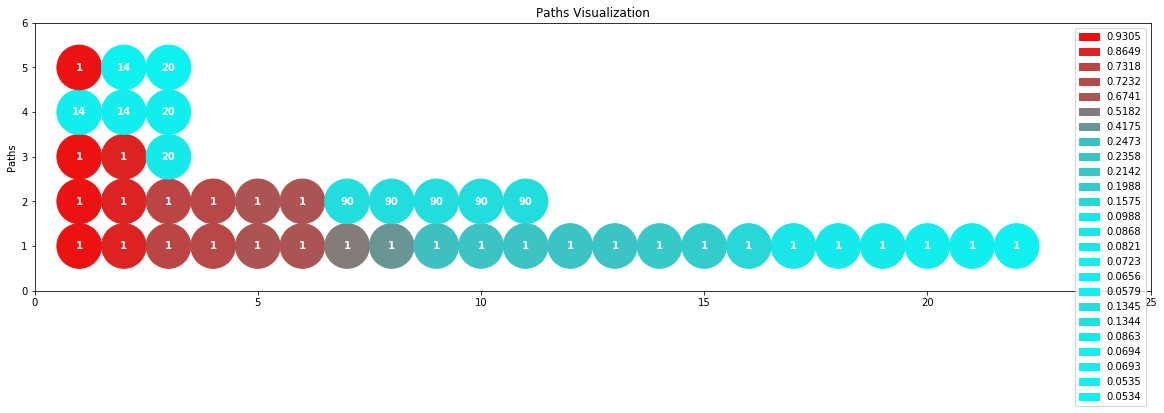

In [237]:

#predicted paths with probabilities

import seaborn as sns
import pandas as pd
import math
import warnings
from queue import PriorityQueue
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

def path_vis():
    global path
    global path_df

    path_df = path_df.reset_index(drop=True)
    # create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(20, 20))
    ax1 = fig2.add_subplot(111, aspect='equal')

    limsx = (0, 25)
    limsy = (0, path_df['PathId'].nunique()+1)

    path_counter = 1
    prev_path = path_df.loc[0, 'PathId']

    for i in range(0, len(path_df)):
        if prev_path!= path_df.loc[i, 'PathId']:
            prev_path = path_df.loc[i, 'PathId']
            path_counter = path_counter + 1

        x = path_df.loc[i, 'Hour']
        y = path_counter
        circ = Circle((x, y), radius=0.5, color=(path_df.loc[i, 'Prob'], 1-path_df.loc[i, 'Prob'], 1-path_df.loc[i, 'Prob']), label=round(path_df['Prob'][i], 4))
        ax1.add_patch(circ)
        ax1.annotate(str(int(path_df.loc[i, 'StateId'])), (x, y),
                                 color='w', weight='bold', fontsize=10, ha='center', va='center')

    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.ylabel('Paths')
    plt.title('Paths Visualization')
    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()

def meters(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat / 2) * math.sin(dLat / 2) + math.cos(lat1 * math.pi / 180) * math.cos(
        lat2 * math.pi / 180) * math.sin(dLon / 2) * math.sin(dLon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d * 1000  # meters


def add_in_queue(prob, states, hour, from_state, from_hour, from_prob):
    global q

    size = prob.size
    for i in range(0, size):
        q.put((1 - prob[0][i], states[i], prob[0][i], hour, from_state, from_hour, from_prob))


def ent(data):
    entropy = 0
    size = data.size
    for i in range(0, size):
        entropy = entropy + (- data[0][i] * math.log(data[0][i], 2))
    return entropy


def print_q():
    while not q.empty():
        next_item = q.get()
        print(next_item)


def print_tree():
    global path
    global path_df

    path_df = path.copy()

    path_df.loc[0, 'PathId'] = 1
    path.loc[0, 'PathId'] = 1
    for i in range(1, len(path)):
        #continuation of a path
        if ((path.loc[i, 'Hour'] == path.loc[i-1, 'Hour'] + 1) and
            (path.loc[i, 'FromState'] == path.loc[i-1, 'StateId']) and
                (path.loc[i, 'FromHour'] == path.loc[i-1, 'Hour']) and
                (path.loc[i, 'FromProb'] == path.loc[i-1, 'Prob'])):
            path.loc[i, 'PathId'] = path.loc[i - 1, 'PathId']
            path_df.loc[i, 'PathId'] = path.loc[i - 1, 'PathId']
        #new path
        else:
            path_id = 0
            row_count = 0
            sim_path_count = 0
            #look for parent     
            for j in range(0, i):
                row_count = row_count + 1
                if (path.loc[j, 'StateId'] == path.loc[i, 'FromState'] and
                    path.loc[j, 'Hour'] == path.loc[i, 'FromHour'] and
                        path.loc[j, 'Prob'] == path.loc[i, 'FromProb']):
                    path_id = path.loc[j, 'PathId']
                    break
                    
            if path_id != 0:
                #if it is the continuation of an old path
                if path.loc[row_count-1, 'PathId'] != path.loc[row_count, 'PathId']:
                    path.loc[i, 'PathId'] = path_id
                    path_df.loc[i, 'PathId'] = path_id
                #new path with existing tail from parent
                else:
                    new_path_id = path['PathId'].max() + 1
                    path.loc[i, 'PathId'] = new_path_id
                    path_df.loc[i, 'PathId'] = new_path_id
                    last_row = len(path_df)
                    for j in range(0, row_count):
                        if (path.loc[j, 'PathId'] == path_id):
                            path_df.loc[last_row+j] = path_df.loc[j]
                            path_df.loc[last_row+j, 'PathId'] = new_path_id
            else:
                new_path_id = path['PathId'].max() + 1
                path.loc[i, 'PathId'] = new_path_id
                path_df.loc[i, 'PathId'] = new_path_id 
            
    path_df = path_df.sort_values(['PathId', 'Hour', 'Prob', ])
    path_df = path_df.reset_index(drop=True)
    path_vis()
    
def path_conf():
    global path
    global path_df
    
    tot_states = trained_model_df['StateId'].nunique()
    state_list = trained_model_df['StateId'].unique()
    path_row = 0

    if hour == 23:
        nxt_hour = 0
    else:
        nxt_hour = hour + 1

    for i in range(0, len(trained_model_df)):

        trn_lat = trained_model_df['AvgLat'][i]
        trn_lon = trained_model_df['AvgLon'][i]
        act_state = trained_model_df['StateId'][i]

        if meters(trn_lat, trn_lon, lat, lon) <= state_d_thrhld:

            from_col_no = tot_states * nxt_hour + 5
            to_col_no = from_col_no + tot_states
            predic_list = trained_model_df.iloc[i:i + 1, from_col_no:to_col_no].as_matrix()
            add_in_queue(predic_list, state_list, nxt_hour, "start", hour, 1)

            while not q.empty():
                next_item = q.get()
                if next_item[2] > confidence_thrshld:
                    read_hour = next_item[3]
                    next_row = trained_model_df.loc[trained_model_df['StateId'] == (next_item[1])]

                    if read_hour == 23:
                        next_hour = 0
                    else:
                        next_hour = read_hour + 1
                        
                    from_col_no = tot_states * next_hour + 5
                    to_col_no = from_col_no + tot_states
                    next_list = next_row.iloc[0:1, from_col_no:to_col_no].as_matrix()
                    next_list = next_list * next_item[2]
                    from_hour = next_item[3]
                    from_state = next_item[1]
                    from_prob = next_item[2]

                    path.loc[path_row, 'StateId'] = next_item[1]
                    path.loc[path_row, 'Prob'] = next_item[2]
                    path.loc[path_row, 'Hour'] = next_item[3]
                    path.loc[path_row, 'FromState'] = next_item[4]
                    path.loc[path_row, 'FromHour'] = next_item[5]
                    path.loc[path_row, 'FromProb'] = next_item[6]
                    path_row = path_row + 1

                    add_in_queue(next_list, state_list, read_hour+1, from_state, from_hour, from_prob)
            
            if not path.empty:
                print_tree()
                #print(path_df)
            else:
                print("No paths with this confidence threshold found.")
            break


# -------------------------------------------------------------------------------------------------------
# month = "200904"
# user = "000"
# hour = 0
# confidence_thrshld = 0.05
# state_d_thrhld = 200
# lat = 39.99998468
# lon = 116.3272194
# src_path = "C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results"

q = PriorityQueue()
path = pd.DataFrame()
path_df = pd.DataFrame()

trained_model_file = src_path + "/User " + user + "/" + month + "/markovchains/final.csv"
file1 = src_path + "/User " + user + "/" + month + "/path_df.csv"
file2 = src_path + "/User " + user + "/" + month + "/path.csv"

path['StateId'] = 0
path['Hour'] = 0
path['Prob'] = 0
path['FromState'] = 0
path['FromHour'] = 0
path['FromProb'] = 0

trained_model_df = pd.read_csv(trained_model_file, header=0)

path_conf()

#path_df.to_csv(file1, sep='\t', encoding='utf-8')
#path.to_csv(file2, sep='\t', encoding='utf-8')

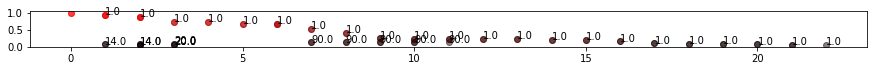

In [238]:
#test
fig2 = plt.figure(figsize=(15, 15))
ax1 = fig2.add_subplot(111, aspect='equal')

N = len(path)
area = (40 * np.random.rand(N))**2  # 0 to 15 point radii

for i in range(0, len(path)):
    x = path.loc[i, 'FromHour']
    y = path.loc[i, 'FromProb']
    color=(path.loc[i, 'FromProb'], 0, 0)
    ax1.scatter(x, y, c=color ,alpha=0.5,  marker='o', linestyle='-' )
    
    x = path.loc[i, 'Hour']
    y = path.loc[i, 'Prob']
    annot = path.loc[i, 'StateId']
    color=(path.loc[i, 'Prob'], 0, 0)
    ax1.scatter(x, y, c=color ,alpha=0.5, marker='o', linestyle='-')
    ax1.annotate(annot, (x, y))
    
plt.savefig('C:/Users/12sha/Documents/thesislocation/code_/stay points/v0.6 results/User 000/200904/test.png')